In the [new growth](./new_growth.ipynb) notebook, we calculate the growth
history of a spherical particle in a cubic box liquid of iron containing oxygen
assuming the liquid is always well mixed. The growth rate starts fast
(as the system is far from equilibrium) then slows down and stops as
oxygen partitions from the growing solid into the liquid and phase
equilibrium is approached. However, in a more realistic case oxygen expelled from
the growing solid iron particle will not instantly mix throughout the liquid
volume and a compositional boundary layer will be expected to form. This is
expected to slow the rate of growth (and thus delay the approach to equilibrium).
If we imagine the particle is sinking as it grows the thickness of the boundary layer
is expected to be set by the sinking velocity, which depends on the radius of the
particle. The interplay between thermodynamics, chemical diffusion, Stokes
flow, and boundary layer dynamics could then be rather complicated - but we may
be able to perfom a non-equilibrium
calculation akin to the equilbrium calculation of sinking velocity. This could 
let us link the growth rate of the core to the number density of sinking particles,
and thus estimate the sesimic properties of the F-layer.

This notebook is split into three sections. The first replicates the calculation in
the new growth notebook taking a slightly different approach to the way oxygen content
is conserved. The second considers the growth of a
single particle in a box including the chemical boundary layer, but excluding
movment of the particle (the boundary layer thickness is imposed). The third
accounts for sinking and leads to everything we need for our F-layer calculation. In all
cases growth is coupled to the thermodynamics of Fe-FeO and, for the second two cases,
diffusion through the boundary layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import scipy.integrate as spi
import scipy.optimize as spo

import growth
import falling
import feo_thermodynamics

Pr =  0.09075  Sc =  999.9999999999999


In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Well mixed case 

In this case the composition outside the sphere is uniform and changes only through the growth of the particle. 

As in the new growth notebook, we consider a box of Fe-FeO melt with a fixed overall composition, pressure and temperature starting with a seed crystals with a small radius. We timestep the system and track the composition of the melt and size of the crystal as it grows or dissolves and the system approaches (phase) equilibrium. However, instead
of tracking the mole fraction solid and using this to evaluate the composition of the melt we assume a spherical
geometry and integrate the mole fraction Fe in the system. Constraining this to be fixed makes sure we conserve
mass of Fe and O, but allows us to extend the calculation to incoporate a boundary layer. 

We assume a spherical particle of Fe at the origin of a spherical region. The particle radius, $r_p$ increases or
decreases at a rate set by the chemical potential difference between the solid Fe and the liquid FeO on each side
of the particle boundary, $\Delta\mu(x_l(r_p))$, following Sun et al.

\begin{equation*}
\frac{\mathrm{d} r_p}{\mathrm{d} t} = k_0 \left[1 - \exp\left(\frac{\Delta\mu(x_l)}{k_B T}\right)  \right]
\label{eq:drpdt} \tag{1}
\end{equation*}

Where $x_l$ is the composition of the liquid (in mol. fraction Fe),
$k_0$ is a material dependent growth rate of the
solid in the absence of diffusive effects (probably high for pure metals), $k_B$ is the Boltzmann constant, $t$ is time and $T$ is temperature. 

For an initial liquid composition $x_i$ in a spherical region of radius $r_{max}$, mass conservation implies:

\begin{equation*}
\frac{4}{3}\pi r^3 x_i = \int_0^{r_{max}} 4 \pi r^2 x(r) \mathrm{d}r
\label{eq:massconc} \tag{2}
\end{equation*}

where

\begin{equation*}
x(r) = \begin{cases} 
      1.0 & r \leq r_p  \\
      x_l & r_p\leq r\leq R  
   \end{cases}
\label{eq:xl} \tag{3}
\end{equation*}

Equations \eqref{eq:drpdt}--\eqref{eq:xl} will be used below.

In [5]:
# Functions for mass conservation

@numba.vectorize()
def x_r_well_mixed (r, rp, xl):
    """Implements eqn (1) above"""
    if r < rp:
        x = 1.0
    else:
        x = xl
    return x

@numba.jit()
def intergrand_well_mixed(r, rp, xl):
    """Integrand of eqn 2 above"""
    return 4.0 * np.pi * r**2 * x_r_well_mixed(r, rp, xl)

def total_composition_well_mixed(rp, xl, r_max):
    """Integral on RHS of eqn (2)"""
    y, err, infodict = spi.quad(intergrand_well_mixed, 0.0, r_max, args=(rp, xl), full_output=1)
    
    return y

In [6]:
def _total_composition_well_mixed_error(xl, rp, xi, rtot):
    """
    For a given xl compute the difference between the composition and the pure
    liquid composition. When this is zero we have a consistent solution
    """
    # Calculate total composition for this configuration
    xtot = total_composition_well_mixed(rp, xl, rtot)
    xtot_pure_melt = 4/3 * np.pi * rtot**3 * xi
    error = xtot - xtot_pure_melt
    return error

def well_mixed_growth_rate(rp, xi, rtot, temperature, pressure, k0):
    """
    Compute growth rate of a particle of Fe from an FeO liquid accounting in a well mixed liquid
    
    For an Fe particle of radius rp (m) in a spherical container of radius rtot (m)
    calculate drp/dt (in m/s) assuming a well mixed liquid and fixed total composition xi 
    (mol frac Fe) pressute (in GPa) and temperature (K). We also need a prefactor for growth 
    (k0, in m/s).
    
    Returns the growth rate and the self-consistent composition aof the liquid.
    """
    xl = spo.brentq(_total_composition_well_mixed_error, 0.00000001, 0.999999999, 
                    args=(rp, xi, rtot))
    error = _total_composition_well_mixed_error(xl, rp, xi, rtot)
    v = growth.growth_velocity_feo(xl, pressure, temperature, k0)
    return v, xl, error

In [24]:
# Solution for different radii
xi   = 0.95    # mol frac Fe
t    = 5000.0  # Temperature
p    = 330.0   # Pressure
k0   = 150.0   # Growth rate prefactor
rtot = 1.0     # rmax

total_volume = 4/3 * np.pi * rtot**3

print('{:8s} {:8s} {:8s} {:8s} {:8s}'.format("rp", "v", "xl", "vf", "error"))

for rp in [1.0E-10, 1.0E-8, 1.0E-6, 1.0E-4, 1.0E-2, 0.10, 0.25, 0.5, 0.75, 0.9, 0.91, 
           0.92, 0.93, 0.94, 0.95]:
    v, xl, error = well_mixed_growth_rate(rp, xi, rtot, t, p, k0)
    volume_fraction_solid = (4/3 * np.pi * rp**3) / total_volume 
    print('{:6.2e} {:6.2e} {:6.2e} {:6.2e} {:6.2e}'.format(rp, v, xl, volume_fraction_solid, error))


rp       v        xl       vf       error   
1.00e-10 2.66e+01 9.50e-01 1.00e-30 -4.44e-16
1.00e-08 2.66e+01 9.50e-01 1.00e-24 -4.44e-16
1.00e-06 2.66e+01 9.50e-01 1.00e-18 -4.44e-16
1.00e-04 2.66e+01 9.50e-01 1.00e-12 -4.44e-16
1.00e-02 2.66e+01 9.50e-01 1.00e-06 8.88e-16
1.00e-01 2.66e+01 9.50e-01 1.00e-03 1.51e-12
2.50e-01 2.65e+01 9.49e-01 1.56e-02 1.02e-12
5.00e-01 2.57e+01 9.43e-01 1.25e-01 0.00e+00
7.50e-01 2.17e+01 9.14e-01 4.22e-01 8.88e-16
9.00e-01 6.25e+00 8.15e-01 7.29e-01 -4.44e-16
9.10e-01 2.93e+00 7.97e-01 7.54e-01 4.07e-13
9.20e-01 -1.44e+00 7.74e-01 7.79e-01 0.00e+00
9.30e-01 -7.47e+00 7.44e-01 8.04e-01 4.44e-16
9.40e-01 -1.63e+01 7.05e-01 8.31e-01 -4.44e-16
9.50e-01 -3.05e+01 6.49e-01 8.57e-01 -4.44e-16


<ipython-input-19-cb24f49d87db>:7: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(r, intergrand_well_mixed(r, 0.9, 0.80)/(4*np.pi*r*r), alpha=0.5)


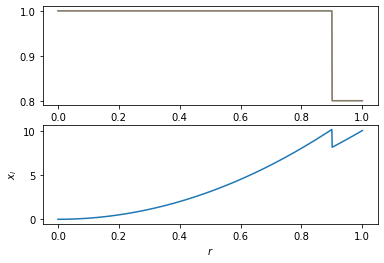

In [19]:
# Quick plot of the composition
# Lower plot shows effect of spherical geometry
r = np.linspace(0.0, rtot, 1000)
fig, ax = plt.subplots(nrows=2)
plt.xlabel("$r$")
plt.ylabel("$x_l$")
ax[0].plot(r, x_r_well_mixed(r, 0.9, 0.80))
ax[0].plot(r, intergrand_well_mixed(r, 0.9, 0.80)/(4*np.pi*r*r), alpha=0.5)
ax[1].plot(r, intergrand_well_mixed(r, 0.9, 0.80))

plt.show()

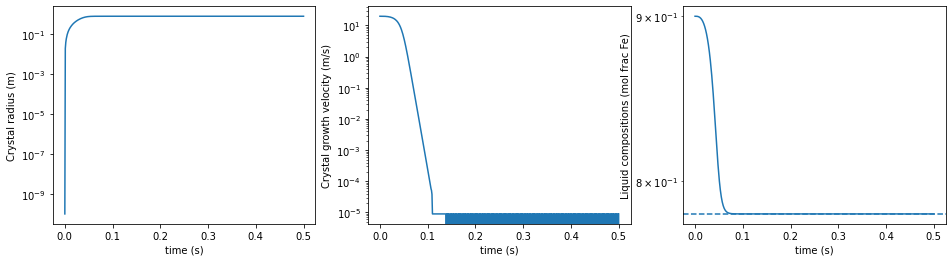

In [36]:
# Forward Euler solution for evolution in a well mixed fixed box...

r0           = 1.0E-10 # initial radius, m
t            = 5000.0  # temperature, K
p            = 330.0   # GPa
xi           = 0.9     # Overall composition, mol frac Fe
k0           = 150.0   # growth rate prefactor, m/s
r_tot        = 1.0     # initial box radius
time_step    = 0.001   # s
total_time   = 0.50    # s
total_volume = (4.0/3.0) * np.pi * r_tot**3

# For plotting only - what is equilibrium?
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(xi, p, t)


rs     = [] # List to store radii
ts     = [] # List to store times
vs     = [] # List of growth velocites
x_ls   = [] # List of liquid compositions
errors = []

time = 0.0
rp   = r0
v, xl, error = well_mixed_growth_rate(rp, xi, rtot, t, p, k0)
rs.append(rp)
ts.append(time)
vs.append(v)
x_ls.append(xl)
errors.append(error)

while time < total_time:
    # grow particles
    rp           = rp + v*time_step
    solid_volume = (4.0/3.0) * np.pi * r**3
    v, xl, error = well_mixed_growth_rate(rp, xi, rtot, t, p, k0)
    time         = time + time_step
    rs.append(rp)
    ts.append(time)
    vs.append(v)
    x_ls.append(xl)
    errors.append(error)
    
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,4))

ax1.set_yscale("log")
ax1.plot(ts, rs)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Crystal radius (m)')

ax2.set_yscale("log")
ax2.plot(ts, vs)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Crystal growth velocity (m/s)')

ax3.set_yscale("log")
ax3.plot(ts, x_ls)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Liquid compositions (mol frac Fe)')
ax3.axhline(x_lq_eq, ls='--')

## Boundary layer

This model mirrors the setup above but we allow a compositional boundary layer to form around the particle.
The boundary layer forms because there is a flux of oxygen out of the particle as it grows, locally
enriching the oxygen content (decreasing $x$). The increase in oxygen content as the particle grows
is balanced by diffusion away from the boundary (in the liquid) and, following a derivation in the
overleaf document, the relationship between crystal growth rate and oxygen flux at the interface is
given by:

$$\left. \frac{\partial x}{\partial r}\right|_{r=r_p} = \frac{x_p}{D_l} \frac{\mathrm{d} r_p}{\mathrm{d} t} $$

where $x_p$ is the liquid composition at the particle interface (at $r_p$), $D_l$ is the oxygen diffusion
coefficent, and $t$ is time. $r$ is measured outwards from the center of the particle. The growth rate still also
depends on the liquid composition at the particle interface via the chemical potential change as above.

We assume that the boundary layer structure is linear, increasing from some value at the interface, given by
$x_p = x(r_p)$, to some other value, $x_l = x(r_p + \delta)$, at and beyond the outer edge of the boundary layer (which has a
thickness $\delta$). This allows us to relate the structure of the boundary layer to the growth rate of the
particle:

$$ x(r_p+\delta) - x(r_p) = \frac{\delta x(r_p)}{D_L} \frac{\mathrm{d} r_p}{\mathrm{d} t} $$

With this setup we can write the composition in terms of $r$:

$$ x(r) = \begin{cases} 
      1.0 & r \leq r_p  \\
      (x_p - x_l)(r - r_p)/\delta + x_p & r_p\leq r\leq r_p + \delta \\
      x_l & r_p + \delta \leq r 
   \end{cases}$$
   
which is then integrated as above to maintain the total composition, $x_i$. Note that this means that the
growth rate depends on an additional material property (the diffusion coefficent) and on the boundary layer
thickness (which we impose - and should depend on the particles velocity with respect to the liquid). The
solution explicitly couples thermodynamics at the interface to the structure of the boundary layer in a way
that will (generally) slow growth but without imposing Loper's assumption of not having surface effects. 
Coupling with the dynamics comes in the next section (via the boundary layer thickness). 

The solution now requiers calculation of the growth rate inside the root finding procedure to conserve mass
(which is why things were set up as they were above). We assume here (and above) that changing the composition
of the liquid or growing the solid does not change the volume of the system. This is not consistent with the
thermodynamics, but the best way to introduce this effect (and thus impose constant pressure) is not obvious.

Our solution proceeds as follows:

1. For a given $r_p$ and $x_p$
2. Compute $\frac{\mathrm{d} r_p}{\mathrm{d} t}$ from the thermodynamics
3. Compute $\left. \frac{\partial x}{\partial r}\right|_{r=r_p}$ for this growth rate
4. Compute $x_l$ from the boundary layer thickness and the gradient from step 3.
5. Calculate the difference between the oxygen content in the box and initial oxygen content
6. Update $x_p$ such that the difference goes towards zero and return to 2. This 
gives eventually the boundary layer structure and growth rate in a consistent way.
7. Grow the particle (to a new $r_p$ and iterate again from 1.

In [34]:
@numba.vectorize()
def x_r (r, rp, delta, xl, xp):
    if r < rp:
        comp = 1.0
    elif r < (rp + delta):
        comp = (xl - xp)*(r - rp)/delta + xp
    else:
        comp = xl
    return comp

@numba.jit()
def intergrand(r, rp, delta, xl, xp):
    return 4.0 * np.pi * r**2 * x_r(r, rp, delta, xl, xp)

def total_composition(rp, delta, xl, xp, r_max):
    # specifing function discontiunities as breakpoints reduces errors here.
    y, err, infodict = spi.quad(intergrand, 0.0, r_max, args=(rp, delta, xl, xp), points=(rp, rp+delta), full_output=1)
    return y, err
    
    


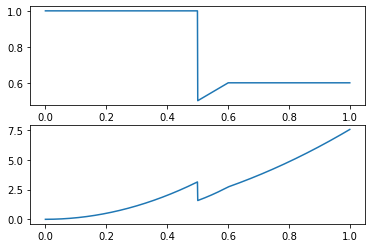

1.0
1.0
1.0
(2.7048065549856926, 3.0029385145021655e-14)


In [35]:
# Check boundary layer structure
rp    = 0.5
delta = 0.1
xl = 0.6
xp = 0.5

r = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(r, x_r(r, rp, delta, xl, xp))
ax[1].plot(r, intergrand(r, rp, delta, xl, xp))

plt.show()

print(x_r(0.02, rp, delta, xl, xp))
print(x_r(0.21, rp, delta, xl, xp))
print(x_r(0.22, rp, delta, xl, xp))

print(total_composition(rp, delta, xl, xp, 1.0))

In [37]:
def _total_composition_error(xp, rp, xi, delta, rtot, temperature, pressure, dl, k0, debug=False):
    """
    For a given cl compute the difference between the composition and the pure
    liquid composition. When this is zero we have a consistent solution
    """
    # Compute growth rate for this composition 
    v = growth.growth_velocity_feo(xp, pressure, temperature, k0)
    # This gives us the composition at the edge of the boundary layer
    # because the gradient at the boundary (and hence in the layer)
    # is set by the expulsion rate of O from the growing Fe
    xl = xp + (delta*xp)/dl * v 
    # but oxygen content has changed sign.
    # Calculate total composition for this configuration
    xtot, integration_error = total_composition(rp, delta, xl, xp, rtot)
    xtot_pure_melt = 4/3 * np.pi * rtot**3 * xi
    error = xtot - xtot_pure_melt
    if debug:
        print("Composition error:", error, "intgration error:", integration_error)
    return error

def diffusion_growth_rate(rp, xi, delta, rtot, temperature, pressure, dl, k0, debug=False):
    """
    Compute growth rate of a particle of Fe from an FeO liquid accounting for a diffusional boundary layer
    
    For an Fe particle of radius rp (m) in a spherical container of radius rtot (m)
    calculate drp/dt (in m/s) assuming the presence of a linear boundary layer of
    thickness delta (m) and total composition ci (mol frac Fe) pressute (in GPa) and
    temperature (K). We also need two material properties, the diffusivity of FeO in 
    the liquid (dl, in m^2s^-1) and prefactor for growth (k0, in m/s). We also need
    an initial guess for the liquid composition next to the particle (cl_guess).
    
    Returns the growth rate, the self-consistent composition at the interface
    and the self consistent composition at the outer side of the boundary layer.
    """
    xp, root_result = spo.brentq(_total_composition_error, 1.0E-12, 1.0-1.0E-12, 
                                 args=(rp, xi, delta, rtot, temperature, pressure, dl, k0, debug),
                                 xtol=2.0e-14, disp=True, full_output=True)
    if debug:
        print(root_result)
    v  = growth.growth_velocity_feo(xp, pressure, temperature, k0)
    xl = xp + (delta*xp)/dl * v
    error = _total_composition_error(xp, rp, xi, delta, rtot, temperature, pressure, dl, k0)
    return v, xp, xl, error

In [42]:
r0    = 1.0E-10 # initial radius, m
t     = 5000.0 # temperature, K
p     = 330.0 # GPa
xi    = 0.95 # Overall composition, mol frac Fe
k0    = 150.0 # growth rate prefactor, m/s
delta = 0.05
r_tot = 1.0

print('{:8s} {:8s} {:8s} {:8s} {:8s}'.format("rp", "v", "xp", "xl", "error"))

for rp in [1.0E-10, 1.0E-8, 1.0E-6, 1.0E-4, 1.0E-2, 0.10, 0.25, 0.5, 0.75, 0.9, 0.91, 
           0.92, 0.93, 0.94, 0.95]:
    v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, r_tot, t, p, 1e-9, k0)    
    print('{:6.2e} {:6.2e} {:6.2e} {:6.2e} {:6.2e}'.format(rp, v, xp, xl, error))


rp       v        xp       xl       error   
1.00e-10 4.31e-09 7.82e-01 9.50e-01 4.37e-06
1.00e-08 4.31e-09 7.82e-01 9.50e-01 4.37e-06
1.00e-06 4.31e-09 7.82e-01 9.50e-01 4.37e-06
1.00e-04 4.31e-09 7.82e-01 9.50e-01 4.19e-06
1.00e-02 4.31e-09 7.82e-01 9.50e-01 1.18e-04
1.00e-01 4.32e-09 7.82e-01 9.50e-01 5.75e-05
2.50e-01 4.32e-09 7.82e-01 9.50e-01 6.59e-05
5.00e-01 4.23e-09 7.82e-01 9.47e-01 -4.44e-05
7.50e-01 3.66e-09 7.82e-01 9.24e-01 -2.66e-05
9.00e-01 1.13e-09 7.82e-01 8.26e-01 -9.56e-06
9.10e-01 5.40e-10 7.82e-01 8.03e-01 -5.65e-06
9.20e-01 -2.71e-10 7.82e-01 7.71e-01 3.73e-06
9.30e-01 -1.44e-09 7.82e-01 7.25e-01 9.99e-06
9.40e-01 -3.30e-09 7.82e-01 6.53e-01 2.16e-06
9.50e-01 -6.65e-09 7.82e-01 5.22e-01 -4.21e-06


Radius 0.5 rate 4.2256698140619164e-09 xp 0.7815058165356564 xl 0.9466250934580831 error -4.435401051683385e-05


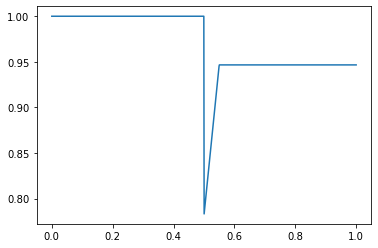

In [43]:
r = np.linspace(0.0, 1.0, 1000)
rp = 0.5
v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, r_tot, t, p, 1e-9, k0)
print("Radius", rp, "rate", v, "xp", xp, "xl", xl, "error", error)
fig, ax = plt.subplots()
ax.plot(r, x_r(r, rp, delta, xl, xp))
plt.show()

In [ ]:
# Forward Euler solution for evolution in a box with fixed boundary layer thickness

r0           = 1.0E-10 # initial radius, m
t            = 5000.0 # temperature, K
p            = 330.0 # GPa
xi           = 0.95 # Overall composition, mol frac Fe
k0           = 150.0 # growth rate prefactor, m/s
r_tot        = 1.0 # initial box radius
delta        = 1.0E-4 # boundary layer thickness - this looks about right, see falling timescale notebook
dl           = 1.0E-9 # diffusion
time_step    = 300.0 # s
total_time   = 7.5E5 # s
total_volume = (4.0/3.0) * np.pi * r_tot**3

# For plotting only - what is equilibrium?
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(xi, p, t)

rs = [] # List to store radii
ts = [] # List to store times
vs = [] # List of growth velocites
x_ps = [] # List of liquid compositions at interface
x_ls = [] # List of liquid compositions outside BL
errors = []

time = 0.0
rp = r0
v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, rtot, t, p, dl, k0)
rs.append(rp)
ts.append(time)
vs.append(v)
x_ps.append(xp)
x_ls.append(xl)
errors.append(error)

while time < total_time:
    # grow particles
    rp = rp + v*time_step
    v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, rtot, t, p, dl, k0)
    time = time + time_step
    rs.append(rp)
    ts.append(time)
    vs.append(v)
    x_ps.append(xp)
    x_ls.append(xl)
    errors.append(error)
    
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,4))

ax1.plot(ts, rs)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Crystal radius (m)')

ax2.plot(ts, vs)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Crystal growth velocity (m/s)')

ax3.plot(ts, x_ls, label='In bulk')
ax3.plot(ts, x_ps, label='At interface')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Liquid compositions (mol frac Fe)')
ax3.axhline(x_lq_eq, ls='--')
ax3.legend()

## Growth rate behaviour

Before moving on to the case where the boundary layer thickness is set by the falling velocity,
it is worth looking at how $k_0$, $D_l$ and $\delta$ control the growth rate. Points with constant
$D_l/\delta$ should plot on top of each other (I think)... We'll just look at the growth
velocity at $x_i = 0.95$ and $r_p = 0.5$ in a sphere of radius 1.0 m.

But some thought about how to plot this is needed.

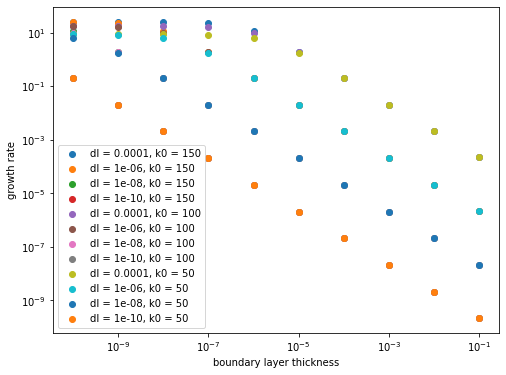

In [13]:
xi = 0.95
rtot = 1.0
rp = 0.5
t = 5000.0
p = 330.0

deltas = [1.0E-10, 1.0E-9, 1.0E-8, 1.0E-7, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2, 0.1]
k0s = [150, 100, 50]
dls = [1.0E-4, 1.0E-6, 1.0E-8, 1.0E-10]
vs = []

fig, ax = plt.subplots(figsize=(8,6))

for k0 in k0s:
    v0, xl, error = well_mixed_growth_rate(rp, xi, rtot, t, p, k0)
    #print(k0, '--', '--', v, error)
    for dl in dls:
        for delta in deltas:
            v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, rtot, t, p, dl, k0)
            vs.append(v)
            #print(k0, delta, dl, v, error)
        ax.scatter(deltas, np.array(vs), label='dl = {}, k0 = {}'.format(dl, k0))
        vs = []

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('growth rate')
ax.set_xlabel('boundary layer thickness')
plt.show()

## Falling sphere

We are now in a position to redo the calculation in [falling_particle](./falling_particle.ipynb) in a way that links
the growth rate to the thermodynamics and the thickness of the boundary layer. Details on how the boundary layer
thickness can be found in [falling_timescale](./falling_timescale.ipynb).

For this calculation we will imagine a particle falling through the F-layer. The location $l_p$ of a particle
changes according to the Stokes equation: 

$$ \frac{d l_p}{d t } = \frac{2}{9} \frac{\Delta \rho g r^2}{\mu} .$$

At time $t^j$ the particle has radius $r_j$. At the next time $t^{j+1}$ the new location is 

$$ l_p^{j+1} = l_j^i - \frac{2}{9} \frac{\Delta \rho g r_j^2}{\mu}\Delta t ,$$

where the minus sign indicates a downward velocity. We use the procedure outlined above to update the size
of the particle. To this we imagine that $xi$ is fixed inside a region of radius $R$ around the particle
(leaving the outside boundary condition for FUTURE DISCUSSION) and does not depend on $l_p$. We also (for the
sake of simplicity here) assume fixed pressure and temperature. The boundary layer thickness, and thus the 
growth rate depends on the particle radius and velocity as described in 
[falling_timescale](./falling_timescale.ipynb). One question is if we reach phase equilibrium before the
particle escapes from the layer. We'll leave this (and linking things to the core growth rate) to another 
notebook.



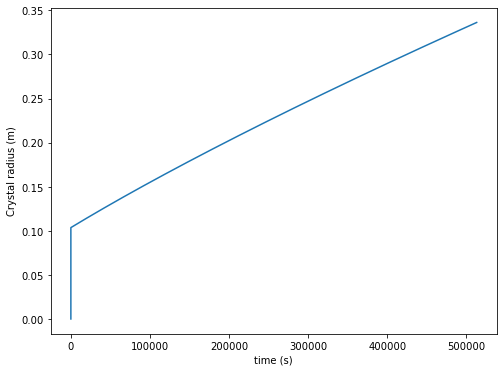

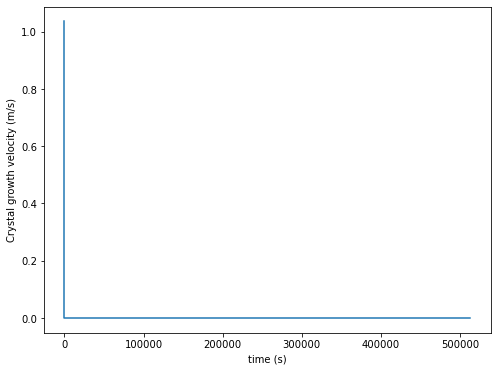

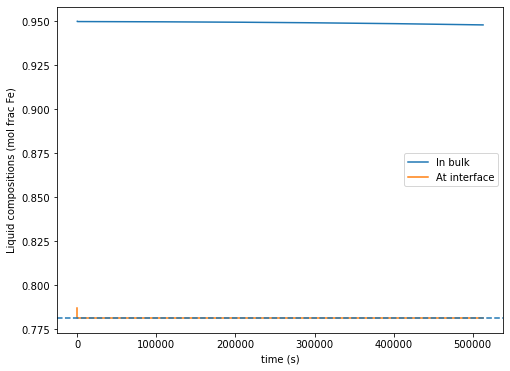

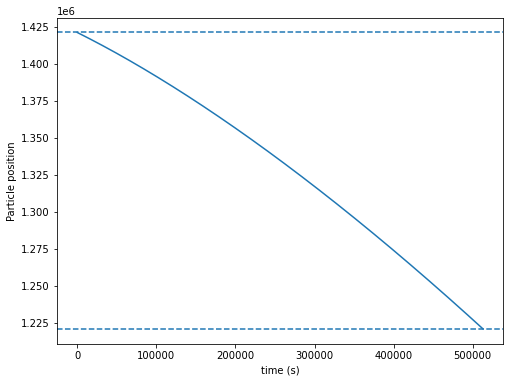

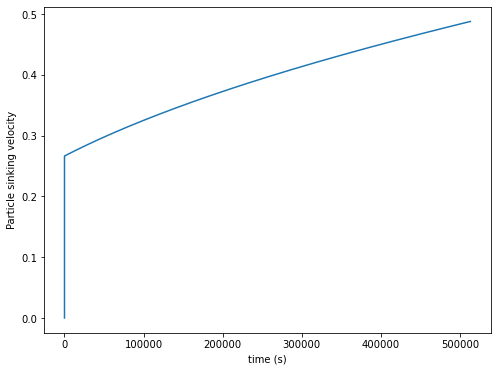

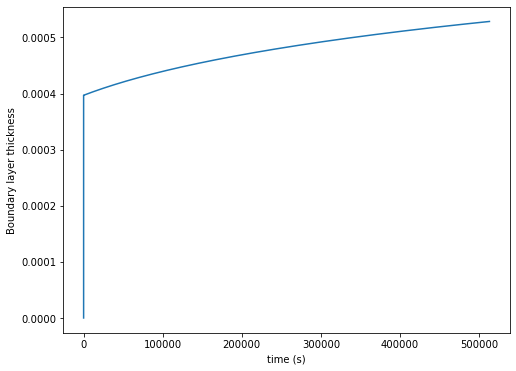

In [14]:
# Forward Euler solution for evolution in a box with fixed boundary layer that evolves as the particle falls

r0 = 1.0E-10 # initial radius, m
t = 5000.0 # temperature, K
p = 330.0 # GPa
xi = 0.95 # Overall composition, mol frac Fe
k0 = 150.0 # growth rate prefactor, m/s
r_tot = 1.0 # initial box radius
dl = 1.0E-9 # diffusion
radius_inner_core = 1221.0e3
radius_top_flayer = radius_inner_core + 200.0e3
mu = 1.0e-6 # kinematic viscosity
g = 3.7 # ICB gravity - from PREM

time_step = 1000.0 # s
total_time = 1000000 # s
total_volume = (4.0/3.0) * np.pi * r_tot**3

# For plotting only - what is equilibrium?
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(xi, p, t)


rs = [] # List to store radii (or particle)
ts = [] # List to store times
vs = [] # List of growth velocites
x_ps = [] # List of liquid compositions at interface
x_ls = [] # List of liquid compositions outside BL
lps = [] # Position of particle at each timestep
v_fallings = []
bl_thickness = []
errors = []

time = 0.0
rp = r0
lp = radius_top_flayer

# Density calculation (with composition at previous step...)
rho_liq, _, _, rho_hcp, _, _ = feo_thermodynamics.densities(xi, p, t)
delta_rho = rho_hcp - rho_liq

# Falling velocity
v_falling  = spo.brentq(falling.fzhang_opt, -1.0, 100.0, 
                             args=(rp, mu, g, delta_rho, rho_liq))

# Boundary layers
_, _, _, _, delta, _, _ = falling.calculate_boundary_layers([rp], mu, g, delta_rho, rho_liq, 
                                                    1.0, dl, radius_top_flayer, radius_inner_core)
delta = delta[0] # Proper vectoriziation of calc boundary layers needed
# Particle growth rate
v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, rtot, t, p, dl, k0)
rs.append(rp)
ts.append(time)
vs.append(v)
x_ps.append(xp)
x_ls.append(xl)
lps.append(lp)
v_fallings.append(v_falling)
bl_thickness.append(delta)
errors.append(error)

while (time < total_time) and (lp > radius_inner_core):
    if time < 1.0:
        this_time_step = 0.1
    else:
        this_time_step = time_step
    # Update particle position
    lp = lp - v_falling*this_time_step
    # grow particles
    rp = rp + v*this_time_step
    # Density calculation (with bulk composition at previous step...)
    rho_liq, _, _, rho_hcp, _, _ = feo_thermodynamics.densities(xl, p, t)
    delta_rho = rho_hcp - rho_liq
    # Falling velocity
    v_falling  = spo.brentq(falling.fzhang_opt, -1.0, 100.0, 
                                 args=(rp, mu, g, delta_rho, rho_liq))
    # Boundary layers
    _, _, _, _, delta, _, _ = falling.calculate_boundary_layers([rp], mu, g, delta_rho, rho_liq, 
                                1.0, dl, radius_top_flayer, radius_inner_core)
    delta = delta[0]
    # Growth rate
    v, xp, xl, error = diffusion_growth_rate(rp, xi, delta, rtot, t, p, dl, k0)
    time = time + this_time_step
    rs.append(rp)
    ts.append(time)
    vs.append(v)
    x_ps.append(xp)
    x_ls.append(xl)
    lps.append(lp)
    v_fallings.append(v_falling)
    bl_thickness.append(delta)
    errors.append(error)
    
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, rs)
ax.set_xlabel('time (s)')
ax.set_ylabel('Crystal radius (m)')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, vs)
ax.set_xlabel('time (s)')
ax.set_ylabel('Crystal growth velocity (m/s)')
plt.show()


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, x_ls, label='In bulk')
ax.plot(ts, x_ps, label='At interface')
ax.set_xlabel('time (s)')
ax.set_ylabel('Liquid compositions (mol frac Fe)')
ax.axhline(x_lq_eq, ls='--')
ax.legend()
plt.show() 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, lps)
ax.set_xlabel('time (s)')
ax.set_ylabel('Particle position')
ax.axhline(radius_inner_core, ls='--')
ax.axhline(radius_top_flayer, ls='--')
plt.show() 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, v_fallings)
ax.set_xlabel('time (s)')
ax.set_ylabel('Particle sinking velocity')
plt.show() 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts, bl_thickness)
ax.set_xlabel('time (s)')
ax.set_ylabel('Boundary layer thickness')
plt.show() 

In [15]:
print(bl_thickness[0:4])
print(rs[0:4])
print(x_ps[0:4])
print(xi)
print(x_ls[0:4])

[2e-10, 0.0003969174594153418, 0.00039687419938280613, 0.0003968741583361663]
[1e-10, 0.10360297966256925, 0.10360303396406755, 0.10360308827144614]
[0.7869411120936193, 0.7815058193427666, 0.7815058193430746, 0.7815058193430756]
0.95
[0.9499999999999809, 0.9499454312146618, 0.9499453112795515, 0.9499452938587297]
